# * TOL Performance

## Import Data Source

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from functools import reduce
import datetime

mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
as_week = 2023023
data_src = f"../../data/raw/Raw-Agg Perf Nationwide_Wk {as_week}.csv"
df = pd.read_csv(data_src, low_memory=False)
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = df[cols]

''' Fix Metric CD List '''
tol_rev_cd_list = ['TB3R000100', 'TB3R000101', 'TB3R000102']

In [3]:
df.shape

(54496, 22)

In [4]:
# ''' Find Metric '''

# df_agg_s = df[df['AGG_TYPE']=='S'].groupby(['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE']).agg({'ACTUAL_SNAP': 'sum', 'TARGET_SNAP': 'sum'}).reset_index()
# df_agg_n = df.loc[df[df['AGG_TYPE']=='N'].groupby('METRIC_CD')['TM_KEY_DAY'].idxmax()].reset_index()
# df_agg_n = df_agg_n[['CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'AGG_TYPE', 'ACTUAL_SNAP', 'TARGET_SNAP']]
# df_metric = pd.concat([df_agg_s, df_agg_n])
# # df_metric

# df_tmp = df_metric[df_metric['PRODUCT_GRP']=="TOL"]#.reset_index()
# df_tmp = df_tmp[df_tmp['METRIC_GRP']=="Revenue"]
# df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Revenue")].reset_index()
# # df_tmp = df_tmp[df_tmp['METRIC_NAME'].str.contains("Sub")]#.reset_index()

# # df_tmp.to_excel('Postpaid_Metric.xlsx', index=False)
# df_tmp

## Data Preporation

In [23]:
''' Rawdata '''

''' Function : Unit Million Baht '''
def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

''' Filters '''
# df = df[df['TM_KEY_MTH'] <= 202305] # MONTH filter
# df = df[df['TM_KEY_WK'] <= 2023022] # WEEK filter
# df = df[df['TM_KEY_DAY'] <= 20230611] # DAY filter
df = df[df['METRIC_CD'].isin(tol_rev_cd_list)]

''' Modify '''
df = df.rename(columns={'ACTUAL_SNAP':'ACT_SNAP', 'ACTUAL_AGG':'ACT_AGG', 'TARGET_SNAP':'TGT_SNAP', 'TARGET_AGG':'TGT_AGG'})
df.loc[:, 'ACT_SNAP'] = unit_mb(df['ACT_SNAP'])
df.loc[:, 'ACT_AGG'] = unit_mb(df['ACT_AGG'])
df.loc[:, 'TGT_SNAP'] = unit_mb(df['TGT_SNAP'])
df.loc[:, 'TGT_AGG'] = unit_mb(df['TGT_AGG'])

''' Add new column '''
df['MTH_DESC'] = pd.to_datetime(df['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
df['WK_LABEL'] = df['TM_KEY_WK'].apply(str).str[5:].astype(int)
df['DAY_LABEL'] = df['TM_KEY_DAY'].apply(str).str[6:].astype(int)

df.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,UOM,PERIOD,ACT_SNAP,ACT_AGG,TGT_SNAP,TGT_AGG,PPN_TM,MTH_DESC,WK_LABEL,DAY_LABEL
46693,20230610,2023023,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,0.0,NaN,NaN,2023-06-13 17:59:16,June,23,10
46694,20230611,2023023,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,0.0,NaN,NaN,2023-06-13 17:59:16,June,23,11
46695,20230612,2023024,202306,20232,2023,Sales & Revenue,Revenue,TRUE,TOL,TB3R000100,...,baht,M,NaN,0.0,NaN,NaN,2023-06-13 17:59:16,June,24,12


In [24]:
''' Create Dataframe '''

''' Aggregate type : S '''
df_agg_s = df[df['AGG_TYPE']=='S']

''' Aggregate type : N '''
df_agg_n = df[df['AGG_TYPE']=='N'].dropna(subset='ACT_SNAP')

In [25]:
''' Period Values '''

curr_yr = df['TM_KEY_YR'].max()
last_yr = df['TM_KEY_YR'].max() - 1
curr_mth = df['TM_KEY_MTH'].max()
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}12') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = df['TM_KEY_WK'].max()
last_wk = df['TM_KEY_WK'].drop_duplicates().shift().max()
curr_day = df['TM_KEY_DAY'].max()
last_ppn_tm = df['PPN_TM'].max()

### DAY : Aggregation (base level)

In [26]:
''' Create Dataframe '''

cols_agg = ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'ACT_AGG', 'TGT_SNAP', 'TGT_AGG']
df_rev_day = df[cols_agg].reset_index()

''' Aggregation '''
df_rev_day['ACT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['ACT_AGG'], df_rev_day['ACT_SNAP'])
df_rev_day['TGT'] = np.where(df_rev_day['AGG_TYPE']=='N', df_rev_day['TGT_AGG'], df_rev_day['TGT_SNAP'])
df_rev_day['%ACHV'] = df_rev_day['ACT'] / df_rev_day['TGT']
df_rev_day['GAP'] = df_rev_day['ACT'] - df_rev_day['TGT']
df_rev_day['LAST_ACT'] = df_rev_day.groupby('METRIC_CD')['ACT'].shift()
df_rev_day['DIFF'] = df_rev_day['ACT'] - df_rev_day['LAST_ACT']
df_rev_day['%DOD'] = (df_rev_day['ACT'] / df_rev_day['LAST_ACT']) - 1

df_rev_day.tail(3)

,index,METRIC_CD,METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_QTR,TM_KEY_YR,MTH_DESC,DAY_LABEL,...,ACT_AGG,TGT_SNAP,TGT_AGG,ACT,TGT,%ACHV,GAP,LAST_ACT,DIFF,%DOD
309,46693,TB3R000100,TOL Revenue,20230610,2023023,202306,20232,2023,June,10,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,46694,TB3R000100,TOL Revenue,20230611,2023023,202306,20232,2023,June,11,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,46695,TB3R000100,TOL Revenue,20230612,2023024,202306,20232,2023,June,12,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
''' Fix Columns Dict '''

cols_dict = {'TOL Revenue': 'TOTAL', 'TOL New Revenue': 'NEW', 'TOL Exisitng Revenue': 'EXIST'}

In [28]:
''' Pivot by KPIS '''

df_rev_day_agg = df_rev_day.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_QTR', 'TM_KEY_YR', 'MTH_DESC', 'DAY_LABEL'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%DOD']).rename(columns=cols_dict).reset_index()
df_rev_day_agg.tail(3)

TM_KEY_DAY TM_KEY_WK TM_KEY_MTH TM_KEY_QTR TM_KEY_YR MTH_DESC  \
METRIC_NAME                                                                 
101           20230610   2023023     202306      20232      2023     June   
102           20230611   2023023     202306      20232      2023     June   
103           20230612   2023024     202306      20232      2023     June   

            DAY_LABEL ACT_SNAP            ...   GAP LAST_ACT            DIFF  \
METRIC_NAME              EXIST NEW TOTAL  ... TOTAL    EXIST NEW TOTAL EXIST   
101                10      NaN NaN   NaN  ...   NaN      NaN NaN   NaN   NaN   
102                11      NaN NaN   NaN  ...   NaN      NaN NaN   NaN   NaN   
103                12      NaN NaN   NaN  ...   NaN      NaN NaN   NaN   NaN   

                       %DOD            
METRIC_NAME NEW TOTAL EXIST NEW TOTAL  
101         NaN   NaN   NaN NaN   NaN  
102         NaN   NaN   NaN NaN   NaN  
103         NaN   NaN   NaN NaN   NaN  

[3 rows x 28 columns]

## ** Yearly

### YR : Aggregation

In [29]:
''' Create Dataframe '''

df_agg_s_yr = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_yr = df_agg_n.loc[df_agg_n.groupby('TM_KEY_YR')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_YR', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_yr = pd.concat([df_agg_s_yr, df_agg_n_yr])

''' Aggregation '''
df_rev_yr['%ACHV'] = df_rev_yr['ACT_SNAP'] / df_rev_yr['TGT_SNAP']
df_rev_yr['GAP'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['TGT_SNAP']
df_rev_yr['LAST_ACT'] = df_rev_yr.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_yr['DIFF'] = df_rev_yr['ACT_SNAP'] - df_rev_yr['LAST_ACT']
df_rev_yr['%YOY'] = (df_rev_yr['ACT_SNAP'] / df_rev_yr['LAST_ACT']) - 1

df_rev_yr#.tail()

,METRIC_CD,METRIC_NAME,TM_KEY_YR,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%YOY
0,TB3R000100,TOL Revenue,2023,S,0.004079,0.004520,0.902383,-0.000441,NaN,NaN,NaN
1,TB3R000101,TOL New Revenue,2023,S,0.000305,0.000459,0.664348,-0.000154,NaN,NaN,NaN
2,TB3R000102,TOL Exisitng Revenue,2023,S,0.003774,0.004062,0.929271,-0.000287,NaN,NaN,NaN


In [30]:
''' Pivot by KPIS '''

df_rev_yr_agg = df_rev_yr.pivot(index='TM_KEY_YR', columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%YOY']).rename(columns=cols_dict).reset_index()
df_rev_yr_agg.tail(3)

TM_KEY_YR  ACT_SNAP                      TGT_SNAP            \
METRIC_NAME               EXIST       NEW     TOTAL     EXIST       NEW   
0                2023  0.003774  0.000305  0.004079  0.004062  0.000459   

                         %ACHV                      ...       GAP LAST_ACT  \
METRIC_NAME    TOTAL     EXIST       NEW     TOTAL  ...     TOTAL    EXIST   
0            0.00452  0.929271  0.664348  0.902383  ... -0.000441      NaN   

                       DIFF            %YOY            
METRIC_NAME NEW TOTAL EXIST NEW TOTAL EXIST NEW TOTAL  
0           NaN   NaN   NaN NaN   NaN   NaN NaN   NaN  

[1 rows x 22 columns]

In [31]:
''' Year to Date Values '''

df_last_yr = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==last_yr][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'ACT_SNAP', 'TGT_SNAP']]
day_cnt_curr_yr = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_YR']==curr_yr) & (df_rev_day_agg['ACT_SNAP']['TOTAL']>0)]['TM_KEY_DAY'].unique())
ytd_last_act = (df_last_yr['ACT_SNAP']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr
ytd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['ACT_SNAP']['TOTAL'].sum()
ytd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_YR']==curr_yr]['TGT_SNAP']['TOTAL'].sum()
ytd_achv = ytd_act / ytd_tgt
ytd_yoy = (ytd_act / ytd_last_act) - 1
ytd_act_gap = ytd_act - ytd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_21492\293886445.py:5: RuntimeWarning: invalid value encountered in scalar divide
  ytd_last_act = (df_last_yr['ACT_SNAP']['TOTAL'].sum() / len(df_last_yr['TM_KEY_DAY'].unique())) * day_cnt_curr_yr


In [32]:
''' Year Chart Values '''

x_yr = df_rev_yr_agg['TM_KEY_YR']
x_yr_axis = np.arange(len(x_yr))

''' Values '''
y_yr_act = df_rev_yr_agg['ACT_SNAP']['TOTAL']
y_yr_tgt = df_rev_yr_agg['TGT_SNAP']['TOTAL']
y_yr_achv = df_rev_yr_agg['%ACHV']['TOTAL']
y_yr_gap = df_rev_yr_agg['GAP']['TOTAL']
y_yr_diff = df_rev_yr_agg['DIFF']['TOTAL']
y_yr_last_act = df_rev_yr_agg['LAST_ACT']['TOTAL']
y_yr_yoy = df_rev_yr_agg['%YOY']['TOTAL']

''' NEW : Values '''
y_yr_act_new = df_rev_yr_agg['ACT_SNAP']['NEW']
y_yr_tgt_new = df_rev_yr_agg['TGT_SNAP']['NEW']
y_yr_achv_new = df_rev_yr_agg['%ACHV']['NEW']
y_yr_gap_new = df_rev_yr_agg['GAP']['NEW']
y_yr_diff_new = df_rev_yr_agg['DIFF']['NEW']
y_yr_last_act_new = df_rev_yr_agg['LAST_ACT']['NEW']
y_yr_yoy_new = df_rev_yr_agg['%YOY']['NEW']

''' EXIST : Values '''
y_yr_act_exist = df_rev_yr_agg['ACT_SNAP']['EXIST']
y_yr_tgt_exist = df_rev_yr_agg['TGT_SNAP']['EXIST']
y_yr_achv_exist = df_rev_yr_agg['%ACHV']['EXIST']
y_yr_gap_exist = df_rev_yr_agg['GAP']['EXIST']
y_yr_diff_exist = df_rev_yr_agg['DIFF']['EXIST']
y_yr_last_act_exist = df_rev_yr_agg['LAST_ACT']['EXIST']
y_yr_yoy_exist = df_rev_yr_agg['%YOY']['EXIST']

### YR : TOL Revenue Summary

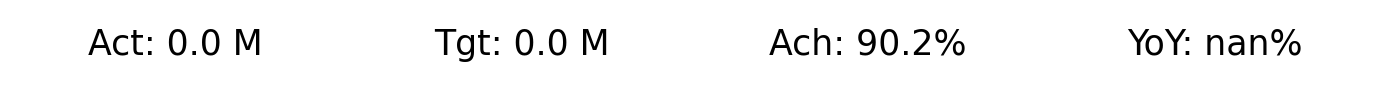

In [33]:
''' Yearly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(ytd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(ytd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(ytd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"YoY: {format(ytd_yoy,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

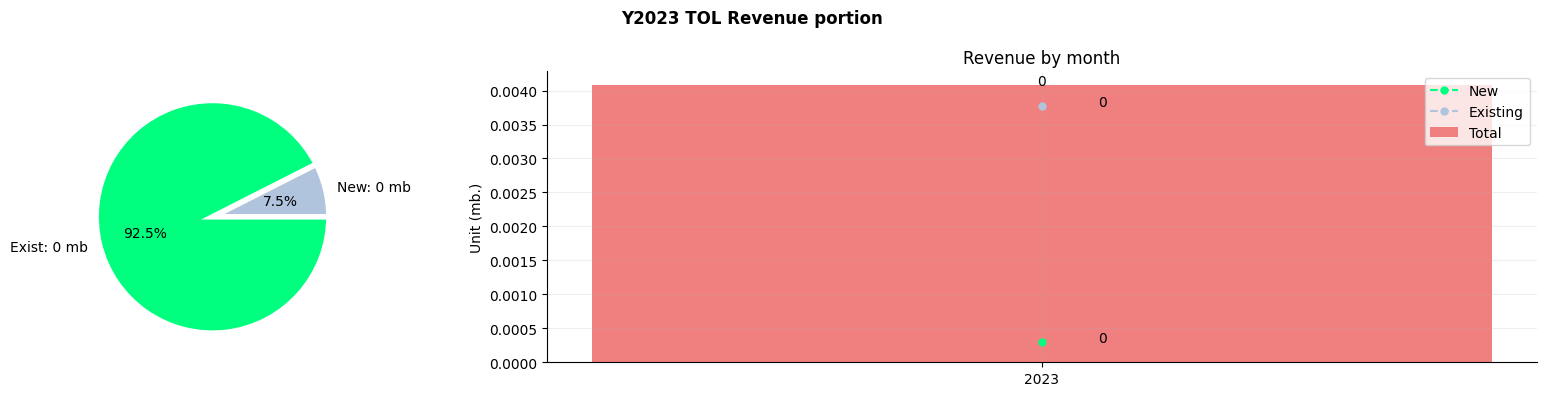

In [34]:
'''' Revenue Portion Chart '''

fig = plt.figure(figsize=(16, 4))
fig.suptitle(f'Y{curr_yr} TOL Revenue portion', weight='bold')
gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1:])

''' ax1 '''
y = np.array([y_yr_act_new.sum(), y_yr_act_exist.sum()])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["lightsteelblue", "springgreen"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
# ax1.text(0, 0, 'Total', ha='center', fontsize=14)

''' ax2 '''
ax2.set_title('Revenue by month')
ax2.bar(x_yr_axis, y_yr_act, label='Total', color='lightcoral')
ax2.plot(x_yr_axis, y_yr_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='New', color='springgreen')
ax2.plot(x_yr_axis, y_yr_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Existing', color='lightsteelblue')
for i in x_yr_axis:
    ax2.annotate(str(format(y_yr_act[i],',.0f')), xy=(x_yr_axis[i], y_yr_act[i]), ha='center')
    ax2.annotate(str(format(y_yr_act_new[i],',.0f')), xy=(x_yr_axis[i]+0.05, y_yr_act_new[i]))
    ax2.annotate(str(format(y_yr_act_exist[i],',.0f')), xy=(x_yr_axis[i]+0.05, y_yr_act_exist[i]))
ax2.set_xticks(x_yr_axis, x_yr)
ax2.set_ylabel('Unit (mb.)', fontsize=10)
ax2.grid(alpha=0.2)
ax2.legend()

fig.tight_layout()
plt.show()

## ** Monthly

### MTH : Aggregation

In [35]:
''' Create Dataframe '''

df_agg_s_mth = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_mth = df_agg_n.loc[df_agg_n.groupby('TM_KEY_MTH')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_MTH', 'MTH_DESC', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_mth = pd.concat([df_agg_s_mth, df_agg_n_mth])

''' Aggregation '''
df_rev_mth['%ACHV'] = df_rev_mth['ACT_SNAP'] / df_rev_mth['TGT_SNAP']
df_rev_mth['GAP'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['TGT_SNAP']
df_rev_mth['LAST_ACT'] = df_rev_mth.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_mth['DIFF'] = df_rev_mth['ACT_SNAP'] - df_rev_mth['LAST_ACT']
df_rev_mth['%MOM'] = (df_rev_mth['ACT_SNAP'] / df_rev_mth['LAST_ACT']) - 1

df_rev_mth.tail(3)

,METRIC_CD,METRIC_NAME,TM_KEY_MTH,MTH_DESC,AGG_TYPE,ACT_SNAP,TGT_SNAP,%ACHV,GAP,LAST_ACT,DIFF,%MOM
9,TB3R000102,TOL Exisitng Revenue,202304,April,S,0.001301,0.001354,0.961238,-0.000052,0.001322,-0.000020,-0.015364
10,TB3R000102,TOL Exisitng Revenue,202305,May,S,0.001152,0.001329,0.866760,-0.000177,0.001301,-0.000150,-0.115021
11,TB3R000102,TOL Exisitng Revenue,202306,June,S,0.000000,0.000000,NaN,0.000000,0.001152,-0.001152,-1.000000


In [36]:
''' Pivot by KPIS '''

df_rev_mth_agg = df_rev_mth.pivot(index=['TM_KEY_MTH', 'MTH_DESC'], columns='METRIC_NAME', 
                                  values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%MOM']).rename(columns=cols_dict).reset_index()
df_rev_mth_agg.tail(3)

TM_KEY_MTH MTH_DESC  ACT_SNAP                      TGT_SNAP  \
METRIC_NAME                         EXIST       NEW     TOTAL     EXIST   
1               202304    April  0.001301  0.000104  0.001406  0.001354   
2               202305      May  0.001152  0.000121  0.001272  0.001329   
3               202306     June  0.000000  0.000000  0.000000  0.000000   

                                    %ACHV            ...       GAP  LAST_ACT  \
METRIC_NAME       NEW     TOTAL     EXIST       NEW  ...     TOTAL     EXIST   
1            0.000153  0.001507  0.961238  0.680967  ... -0.000101  0.001322   
2            0.000187  0.001516  0.866760  0.644182  ... -0.000244  0.001301   
3            0.000000  0.000000       NaN       NaN  ...  0.000000  0.001152   

                                     DIFF                          %MOM  \
METRIC_NAME       NEW     TOTAL     EXIST       NEW     TOTAL     EXIST   
1            0.000080  0.001401 -0.000020  0.000024  0.000004 -0.015364   
2            0.000104  0.001406 -0.000150  0.000016 -0.000133 -0.115021   
3            0.000121  0.001272 -0.001152 -0.000121 -0.001272 -1.000000   

                                 
METRIC_NAME       NEW     TOTAL  
1            0.305852  0.002935  
2            0.157863 -0.094780  
3           -1.000000 -1.000000  

[3 rows x 23 columns]

In [37]:
''' Month to Date Values '''

df_last_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==last_mth][['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'ACT_SNAP', 'TGT_SNAP']]
day_cnt_curr_mth = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_MTH']==curr_mth) & (df_rev_day_agg['ACT_SNAP']['TOTAL']>0)]['TM_KEY_DAY'].unique())
mtd_last_act = (df_last_mth['ACT_SNAP']['TOTAL'].sum() / len(df_last_mth['TM_KEY_DAY'].unique())) * day_cnt_curr_mth
mtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['ACT_SNAP']['TOTAL'].sum()
mtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth]['TGT_SNAP']['TOTAL'].sum()
mtd_achv = mtd_act / mtd_tgt
mtd_mom = (mtd_act / mtd_last_act) - 1
mtd_act_gap = mtd_act - mtd_last_act

C:\Users\Narut4\AppData\Local\Temp\ipykernel_21492\2852849966.py:8: RuntimeWarning: invalid value encountered in scalar divide
  mtd_achv = mtd_act / mtd_tgt
C:\Users\Narut4\AppData\Local\Temp\ipykernel_21492\2852849966.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mtd_mom = (mtd_act / mtd_last_act) - 1


In [39]:
''' Month Chart Values '''

x_mth = df_rev_mth_agg['MTH_DESC']
x_mth_axis = np.arange(len(x_mth))

''' Values '''
y_mth_act = df_rev_mth_agg['ACT_SNAP']['TOTAL']
y_mth_tgt = df_rev_mth_agg['TGT_SNAP']['TOTAL']
y_mth_achv = df_rev_mth_agg['%ACHV']['TOTAL']
y_mth_gap = df_rev_mth_agg['GAP']['TOTAL']
y_mth_diff = df_rev_mth_agg['DIFF']['TOTAL']
y_mth_last_act = df_rev_mth_agg['LAST_ACT']['TOTAL']
y_mth_mom = df_rev_mth_agg['%MOM']['TOTAL']

''' NEW : Values '''
y_mth_act_new = df_rev_mth_agg['ACT_SNAP']['NEW']
y_mth_tgt_new = df_rev_mth_agg['TGT_SNAP']['NEW']
y_mth_achv_new = df_rev_mth_agg['%ACHV']['NEW']
y_mth_gap_new = df_rev_mth_agg['GAP']['NEW']
y_mth_diff_new = df_rev_mth_agg['DIFF']['NEW']
y_mth_last_act_new = df_rev_mth_agg['LAST_ACT']['NEW']
y_mth_mom_new = df_rev_mth_agg['%MOM']['NEW']

''' EXIST : Values '''
y_mth_act_exist = df_rev_mth_agg['ACT_SNAP']['EXIST']
y_mth_tgt_exist = df_rev_mth_agg['TGT_SNAP']['EXIST']
y_mth_achv_exist = df_rev_mth_agg['%ACHV']['EXIST']
y_mth_gap_exist = df_rev_mth_agg['GAP']['EXIST']
y_mth_diff_exist = df_rev_mth_agg['DIFF']['EXIST']
y_mth_last_act_exist = df_rev_mth_agg['LAST_ACT']['EXIST']
y_mth_mom_exist = df_rev_mth_agg['%MOM']['EXIST']

### MTH : TOL Revenue Summary

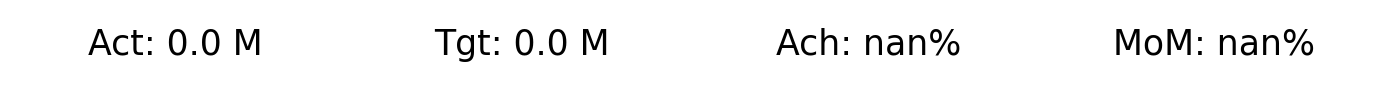

In [40]:
''' Monthly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(mtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(mtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(mtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"MoM: {format(mtd_mom,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

NameError: name 'y_mth_act_tmh' is not defined

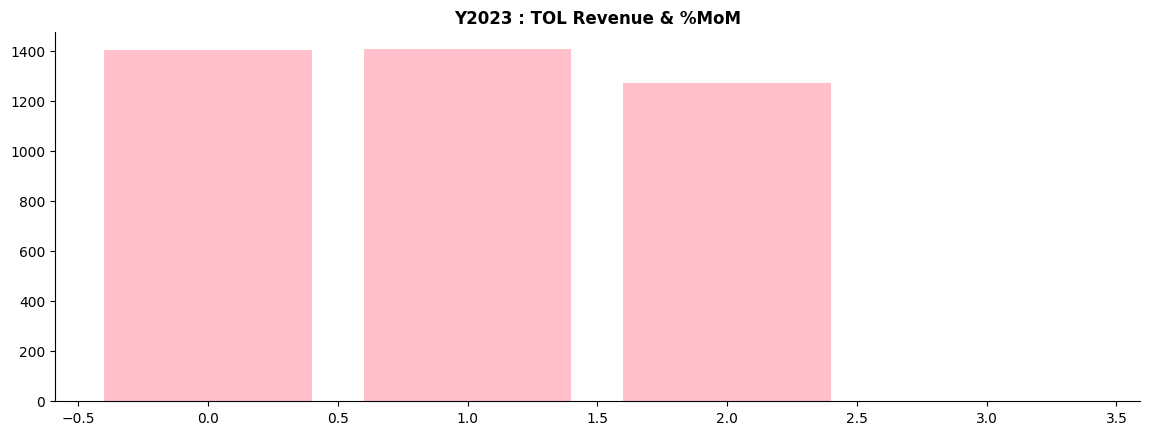

In [22]:
''' Revenue & MoM : MTH Chart '''

plt.figure().set_figwidth(14)

plt.title(f"Y{curr_yr} : TOL Revenue & %MoM", weight='bold')
plt.bar(x_mth_axis, y_mth_act, label='Total', color='pink')
plt.plot(x_mth_axis, y_mth_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_mth_axis, y_mth_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_mth_axis:
    plt.annotate(f"MoM: {format(y_mth_mom[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act[i]+20), ha='center', va='bottom')
    plt.annotate(format(y_mth_act[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-20), ha='center', va='top')
    plt.annotate(f"{format(y_mth_mom_tmh[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_tmh[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-20), ha='center', va='top', fontsize=9)
    plt.annotate(f"{format(y_mth_mom_dtac[i],',.1%')}", xy=(x_mth_axis[i], y_mth_act_dtac[i]+20), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-20), ha='center', va='top', fontsize=9)
    
plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Revenue with New & Existing : MTH Chart '''

plt.figure().set_figwidth(14)

width = 0.3
diff_loc = 0.3

plt.title(f'Y{curr_yr} Postpaid Revenue by month(New & Existing)', fontdict={'fontweight': 'bold'})
plt.bar(x_mth_axis-diff_loc, y_mth_act_exist, width, label='Exist', color='pink')
plt.bar(x_mth_axis-diff_loc, y_mth_act_new, width, label='New', color='hotpink', bottom=y_mth_act_exist)
plt.bar(x_mth_axis, y_mth_act_exist_tmh, width, label='TMH: Exist', color='lightsalmon')
plt.bar(x_mth_axis, y_mth_act_new_tmh, width, label='TMH: New', color='orangered', bottom=y_mth_act_exist_tmh)
plt.bar(x_mth_axis+diff_loc, y_mth_act_exist_dtac, width, label='DTAC: Exist', color='lightskyblue')
plt.bar(x_mth_axis+diff_loc, y_mth_act_new_dtac, width, label='DTAC: New', color='dodgerblue', bottom=y_mth_act_exist_dtac)
for i in x_mth_axis:    
    plt.annotate(format(y_mth_act_exist[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new[i],',.0f'), xy=(x_mth_axis[i]-diff_loc, y_mth_act_exist[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+100), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]-300), ha='center', fontsize=9)
    plt.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i]+diff_loc, y_mth_act_exist_dtac[i]+100), ha='center', fontsize=9)

plt.ylabel('Unit (mb.)')
plt.xticks(x_mth_axis, x_mth)
plt.legend()
plt.tight_layout()
plt.show()

### MTH : Postpaid Revenue : TMH vs DTAC

In [ ]:
''' Revenue portion of New/Existing : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(12, 4))
fig.suptitle(f'Y{curr_yr} Postpaid Revenue portion of New/Existing : TMH vs DTAC', weight='bold')
gs = GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_exist_tmh)])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "lightsalmon"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.text(0, 0, 'TMH', ha='center', fontsize=14)

''' ax2 '''
y = np.array([sum(y_mth_act_new_dtac), sum(y_mth_act_exist_dtac)])
mylabels = [f"New: {format(y[0],',.0f')} mb", f"Exist: {format(y[1],',.0f')} mb"]
mycolors = ["dodgerblue", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.text(0, 0, 'DTAC', ha='center', fontsize=14)

fig.tight_layout()
plt.show()

In [ ]:
''' Revenue : TMH vs DTAC : MTH Chart '''

fig = plt.figure(figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid Revenue : TMH vs DTAC by month', weight='bold')
gs = GridSpec(3, 4)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[0, :])
ax4 = fig.add_subplot(gs[1, 1:])
ax5 = fig.add_subplot(gs[2, 1:])

''' ax1 '''
y = np.array([sum(y_mth_act_new_tmh), sum(y_mth_act_new_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["orangered", "dodgerblue"]
ax1.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax1.set_ylabel('New', weight='bold')

''' ax2 '''
y = np.array([sum(y_mth_act_exist_tmh), sum(y_mth_act_exist_dtac)])
mylabels = [f"TMH: {format(y[0],',.0f')} mb", f"DTAC: {format(y[1],',.0f')} mb"]
mycolors = ["lightsalmon", "lightskyblue"]
ax2.pie(y, labels=mylabels, colors=mycolors, autopct='%1.1f%%', wedgeprops = {"linewidth": 4, "edgecolor": "white"})
ax2.set_ylabel('Existing', weight='bold')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='TMH', color='orangered')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='DTAC', color='dodgerblue')
ax3.legend()
ax3.grid(alpha=0.3)
ax3.set_xticks(x_mth_axis, x_mth)
ax3.spines[['top', 'right']].set_visible(False)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_act_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_mth_act_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax4 '''
ax4.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: New', color='orangered')
ax4.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: New', color='dodgerblue')
ax4.legend()
ax4.grid(alpha=0.3)
ax4.set_xticks(x_mth_axis, x_mth)
ax4.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax4.annotate(format(y_mth_act_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax4.annotate(format(y_mth_act_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]), ha='center', va='bottom', fontsize=9)

''' ax5 '''
ax5.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH: Exist', color='orangered')
ax5.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC: Exist', color='dodgerblue')
ax5.legend()
ax5.grid(alpha=0.3)
ax5.set_xticks(x_mth_axis, x_mth)
ax5.spines[['top', 'right', 'left']].set_visible(False)
for i in x_mth_axis:
    ax5.annotate(format(y_mth_act_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax5.annotate(format(y_mth_act_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]), ha='center', va='bottom', fontsize=9)

fig.tight_layout()
plt.show()

### MTH : Postpaid Performance : %Achievement & Gap

In [ ]:
''' Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Postpaid : Performance by month : %Achievement & Gap\n\n \
    ALL: {format(sum(y_mth_act)/sum(y_mth_tgt),',.1%')}({format(sum(y_mth_gap),',.0f')}) \
        TMH: {format(sum(y_mth_act_tmh)/sum(y_mth_tgt_tmh),',.1%')}({format(sum(y_mth_gap_tmh),',.0f')}) \
            DTAC: {format(sum(y_mth_act_dtac)/sum(y_mth_tgt_dtac),',.1%')}({format(sum(y_mth_gap_dtac),',.0f')})", weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv[i],',.1%'), xy=(x_mth_axis[i], y_mth_act[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap[i],',.0f'), xy=(x_mth_axis[i], y_mth_act[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

In [ ]:
''' NEW : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid NEW : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_new, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_new, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_new[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_new[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_new_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_new_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_new_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_new_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_new_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_new_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_new_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_new_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_new_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

In [ ]:
''' EXISTING : Peformance : %Achievement & Gap : MTH Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 7))
fig.suptitle(f'Y{curr_yr} Postpaid EXISTING : Performance by month : %Achievement & Gap', weight='bold')

''' ax1 '''
ax1.plot(x_mth_axis, y_mth_tgt_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_mth_axis, y_mth_act_exist, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_mth_axis, y_mth_last_act_exist, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_mth_axis:
    ax1.annotate(format(y_mth_achv_exist[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist[i]+1), ha='center', va='bottom')
    ax1.annotate(format(y_mth_gap_exist[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist[i]-2), ha='center', va='top')

''' ax2 '''
ax2.plot(x_mth_axis, y_mth_tgt_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_mth_axis, y_mth_act_exist_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_mth_axis, y_mth_last_act_exist_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_mth_axis:
    ax2.annotate(format(y_mth_achv_exist_tmh[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]+1), ha='center', va='bottom')
    ax2.annotate(format(y_mth_gap_exist_tmh[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_tmh[i]-2), ha='center', va='top')

''' ax3 '''
ax3.plot(x_mth_axis, y_mth_tgt_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_mth_axis, y_mth_act_exist_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_mth_axis, y_mth_last_act_exist_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_mth_axis:
    ax3.annotate(format(y_mth_achv_exist_dtac[i],',.1%'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]+1), ha='center', va='bottom')
    ax3.annotate(format(y_mth_gap_exist_dtac[i],',.0f'), xy=(x_mth_axis[i], y_mth_act_exist_dtac[i]-2), ha='center', va='top')

fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_mth_axis, x_mth)
plt.show()

## ** Weekly

### WK : Aggregation

In [ ]:
''' Create Dataframe '''

df_agg_s_wk = df_agg_s.groupby(['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE']).agg({'ACT_SNAP': 'sum', 'TGT_SNAP': 'sum'}).reset_index()
df_agg_n_wk = df_agg_n.loc[df_agg_n.groupby('TM_KEY_WK')['TM_KEY_DAY'].idxmax(), ['METRIC_CD', 'METRIC_NAME', 'TM_KEY_WK', 'WK_LABEL', 'AGG_TYPE', 'ACT_SNAP', 'TGT_SNAP']]
df_rev_wk = pd.concat([df_agg_s_wk, df_agg_n_wk])

# ''' Aggregation '''
df_rev_wk['%ACHV'] = df_rev_wk['ACT_SNAP'] / df_rev_wk['TGT_SNAP']
df_rev_wk['GAP'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['TGT_SNAP']
df_rev_wk['LAST_ACT'] = df_rev_wk.groupby('METRIC_CD')['ACT_SNAP'].shift()
df_rev_wk['DIFF'] = df_rev_wk['ACT_SNAP'] - df_rev_wk['LAST_ACT']
df_rev_wk['%WOW'] = (df_rev_wk['ACT_SNAP'] / df_rev_wk['LAST_ACT']) - 1

# df_rev_wk.to_excel('df_rev_wk.xlsx')
df_rev_wk.tail(3)

In [ ]:
''' Pivot by KPIS '''

df_rev_wk_agg = df_rev_wk.pivot(index=['TM_KEY_WK', 'WK_LABEL'], columns='METRIC_NAME', 
                                values=['ACT_SNAP', 'TGT_SNAP', '%ACHV', 'GAP', 'LAST_ACT', 'DIFF', '%WOW']).rename(columns=cols_dict).reset_index()
df_rev_wk_agg.tail(3)

In [ ]:
''' Week to Date Values '''

df_last_wk = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==last_wk][['TM_KEY_DAY', 'TM_KEY_WK', 'ACT_SNAP', 'TGT_SNAP']]
day_cnt_curr_wk = len(df_rev_day_agg[(df_rev_day_agg['TM_KEY_WK']==curr_wk) & (df_rev_day_agg['ACT_SNAP']['TOTAL']>0)]['TM_KEY_DAY'].unique())
wtd_last_act = (df_last_wk['ACT_SNAP']['TOTAL'].sum() / len(df_last_wk['TM_KEY_DAY'].unique())) * day_cnt_curr_wk
wtd_act = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['ACT_SNAP']['TOTAL'].sum()
wtd_tgt = df_rev_day_agg[df_rev_day_agg['TM_KEY_WK']==curr_wk]['TGT_SNAP']['TOTAL'].sum()
wtd_achv = wtd_act / wtd_tgt
wtd_wow = (wtd_act / wtd_last_act) - 1
wtd_act_gap = wtd_act - wtd_last_act

In [ ]:
''' Week Chart Values '''

x_wk = df_rev_wk_agg['WK_LABEL']
x_wk_axis = np.arange(len(x_wk))

''' Values '''
y_wk_act = df_rev_wk_agg['ACT_SNAP']['TOTAL']
y_wk_act_dtac = df_rev_wk_agg['ACT_SNAP']['TOTAL_DTAC']
y_wk_act_tmh = df_rev_wk_agg['ACT_SNAP']['TOTAL_TMH']
y_wk_tgt = df_rev_wk_agg['TGT_SNAP']['TOTAL']
y_wk_tgt_dtac = df_rev_wk_agg['TGT_SNAP']['TOTAL_DTAC']
y_wk_tgt_tmh = df_rev_wk_agg['TGT_SNAP']['TOTAL_TMH']
y_wk_achv = df_rev_wk_agg['%ACHV']['TOTAL']
y_wk_achv_dtac = df_rev_wk_agg['%ACHV']['TOTAL_DTAC']
y_wk_achv_tmh = df_rev_wk_agg['%ACHV']['TOTAL_TMH']
y_wk_gap = df_rev_wk_agg['GAP']['TOTAL']
y_wk_gap_dtac = df_rev_wk_agg['GAP']['TOTAL_DTAC']
y_wk_gap_tmh = df_rev_wk_agg['GAP']['TOTAL_TMH']
y_wk_diff = df_rev_wk_agg['DIFF']['TOTAL']
y_wk_diff_dtac = df_rev_wk_agg['DIFF']['TOTAL_DTAC']
y_wk_diff_tmh = df_rev_wk_agg['DIFF']['TOTAL_TMH']
y_wk_last_act = df_rev_wk_agg['LAST_ACT']['TOTAL']
y_wk_last_act_dtac = df_rev_wk_agg['LAST_ACT']['TOTAL_DTAC']
y_wk_last_act_tmh = df_rev_wk_agg['LAST_ACT']['TOTAL_TMH']
y_wk_wow = df_rev_wk_agg['%WOW']['TOTAL']
y_wk_wow_dtac = df_rev_wk_agg['%WOW']['TOTAL_DTAC']
y_wk_wow_tmh = df_rev_wk_agg['%WOW']['TOTAL_TMH']

''' NEW : Values '''
y_wk_act_new = df_rev_wk_agg['ACT_SNAP']['NEW']
y_wk_act_new_dtac = df_rev_wk_agg['ACT_SNAP']['NEW_DTAC']
y_wk_act_new_tmh = df_rev_wk_agg['ACT_SNAP']['NEW_TMH']
y_wk_tgt_new = df_rev_wk_agg['TGT_SNAP']['NEW']
y_wk_tgt_new_dtac = df_rev_wk_agg['TGT_SNAP']['NEW_DTAC']
y_wk_tgt_new_tmh = df_rev_wk_agg['TGT_SNAP']['NEW_TMH']
y_wk_achv_new = df_rev_wk_agg['%ACHV']['NEW']
y_wk_achv_new_dtac = df_rev_wk_agg['%ACHV']['NEW_DTAC']
y_wk_achv_new_tmh = df_rev_wk_agg['%ACHV']['NEW_TMH']
y_wk_gap_new = df_rev_wk_agg['GAP']['NEW']
y_wk_gap_new_dtac = df_rev_wk_agg['GAP']['NEW_DTAC']
y_wk_gap_new_tmh = df_rev_wk_agg['GAP']['NEW_TMH']
y_wk_diff_new = df_rev_wk_agg['DIFF']['NEW']
y_wk_diff_new_dtac = df_rev_wk_agg['DIFF']['NEW_DTAC']
y_wk_diff_new_tmh = df_rev_wk_agg['DIFF']['NEW_TMH']
y_wk_last_act_new = df_rev_wk_agg['LAST_ACT']['NEW']
y_wk_last_act_new_dtac = df_rev_wk_agg['LAST_ACT']['NEW_DTAC']
y_wk_last_act_new_tmh = df_rev_wk_agg['LAST_ACT']['NEW_TMH']
y_wk_wow_new = df_rev_wk_agg['%WOW']['NEW']
y_wk_wow_new_dtac = df_rev_wk_agg['%WOW']['NEW_DTAC']
y_wk_wow_new_tmh = df_rev_wk_agg['%WOW']['NEW_TMH']

''' EXIST : Values '''
y_wk_act_exist = df_rev_wk_agg['ACT_SNAP']['EXIST']
y_wk_act_exist_dtac = df_rev_wk_agg['ACT_SNAP']['EXIST_DTAC']
y_wk_act_exist_tmh = df_rev_wk_agg['ACT_SNAP']['EXIST_TMH']
y_wk_tgt_exist = df_rev_wk_agg['TGT_SNAP']['EXIST']
y_wk_tgt_exist_dtac = df_rev_wk_agg['TGT_SNAP']['EXIST_DTAC']
y_wk_tgt_exist_tmh = df_rev_wk_agg['TGT_SNAP']['EXIST_TMH']
y_wk_achv_exist = df_rev_wk_agg['%ACHV']['EXIST']
y_wk_achv_exist_dtac = df_rev_wk_agg['%ACHV']['EXIST_DTAC']
y_wk_achv_exist_tmh = df_rev_wk_agg['%ACHV']['EXIST_TMH']
y_wk_gap_exist = df_rev_wk_agg['GAP']['EXIST']
y_wk_gap_exist_dtac = df_rev_wk_agg['GAP']['EXIST_DTAC']
y_wk_gap_exist_tmh = df_rev_wk_agg['GAP']['EXIST_TMH']
y_wk_diff_exist = df_rev_wk_agg['DIFF']['EXIST']
y_wk_diff_exist_dtac = df_rev_wk_agg['DIFF']['EXIST_DTAC']
y_wk_diff_exist_tmh = df_rev_wk_agg['DIFF']['EXIST_TMH']
y_wk_last_act_exist = df_rev_wk_agg['LAST_ACT']['EXIST']
y_wk_last_act_exist_dtac = df_rev_wk_agg['LAST_ACT']['EXIST_DTAC']
y_wk_last_act_exist_tmh = df_rev_wk_agg['LAST_ACT']['EXIST_TMH']
y_wk_wow_exist = df_rev_wk_agg['%WOW']['EXIST']
y_wk_wow_exist_dtac = df_rev_wk_agg['%WOW']['EXIST_DTAC']
y_wk_wow_exist_tmh = df_rev_wk_agg['%WOW']['EXIST_TMH']

### WK : Postpaid Revenue Summary

In [ ]:
''' Weekly Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(wtd_act,',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(wtd_tgt,',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(wtd_achv,',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"WoW: {format(wtd_wow,',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
''' Revenue by week '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Postpaid Revenue by week', fontdict={'fontweight': 'bold'})
plt.bar(x_wk_axis, y_wk_act, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(format(y_wk_act[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_wk_act_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Revenue %WoW '''

plt.figure().set_figwidth(14)

plt.title(f'Y{curr_yr} Postpaid Revenue %WoW', fontdict={'fontweight': 'bold'})
plt.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_wk_axis, y_wk_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_wk_axis, y_wk_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_wk_axis:
    plt.annotate(f"{format(y_wk_wow[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_tmh[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_tmh[i]+10), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_wk_wow_dtac[i],',.1%')}", xy=(x_wk_axis[i], y_wk_act_dtac[i]+10), ha='center', va='bottom', fontsize=9)
    
plt.xlabel('Week')
plt.ylabel('Unit (mb.)')
plt.xticks(x_wk_axis, x_wk)
plt.grid(alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

### WK : Postpaid Performance : %Achievement & Gap

In [ ]:
''' Peformance : %Achievement & Gap : Week Chart '''

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(14, 8))
fig.suptitle(f"Y{curr_yr} Postpaid : Performance by week : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_wk_axis, y_wk_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
ax1.plot(x_wk_axis, y_wk_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
ax1.plot(x_wk_axis, y_wk_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.2)
for i in x_wk_axis:
    ax1.annotate(format(y_wk_achv[i],',.1%'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_wk_gap[i],',.0f'), xy=(x_wk_axis[i], y_wk_act[i]), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_wk_axis, y_wk_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax2.plot(x_wk_axis, y_wk_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax2.plot(x_wk_axis, y_wk_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: TMH', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.2)
for i in x_wk_axis:
    ax2.annotate(format(y_wk_achv_tmh[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_wk_gap_tmh[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_tmh[i]), ha='center', va='top', fontsize=9)

''' ax3 '''
ax3.plot(x_wk_axis, y_wk_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax3.plot(x_wk_axis, y_wk_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax3.plot(x_wk_axis, y_wk_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last WK: DTAC', color='darkgray')
ax3.legend()
ax3.grid(alpha=0.2)
for i in x_wk_axis:
    ax3.annotate(format(y_wk_achv_dtac[i],',.1%'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='bottom', fontsize=9)
    ax3.annotate(format(y_wk_gap_dtac[i],',.0f'), xy=(x_wk_axis[i], y_wk_act_dtac[i]), ha='center', va='top', fontsize=9)

fig.supxlabel('Week', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_wk_axis, x_wk)
plt.show()

## ** Daily (MTD)

### DAY : Aggregation

In [ ]:
''' Create Dataframe '''

df_rev_day_curr_mth = df_rev_day_agg[df_rev_day_agg['TM_KEY_MTH']==curr_mth].reset_index()
df_rev_day_curr_mth.tail()

In [ ]:
''' Day Chart Values '''

x_day = df_rev_day_curr_mth['DAY_LABEL']
x_day_axis = np.arange(len(x_day))

''' Values '''
y_day_act = df_rev_day_curr_mth['ACT_SNAP']['TOTAL']
y_day_act_dtac = df_rev_day_curr_mth['ACT_SNAP']['TOTAL_DTAC']
y_day_act_tmh = df_rev_day_curr_mth['ACT_SNAP']['TOTAL_TMH']
y_day_tgt = df_rev_day_curr_mth['TGT_SNAP']['TOTAL']
y_day_tgt_dtac = df_rev_day_curr_mth['TGT_SNAP']['TOTAL_DTAC']
y_day_tgt_tmh = df_rev_day_curr_mth['TGT_SNAP']['TOTAL_TMH']
y_day_achv = df_rev_day_curr_mth['%ACHV']['TOTAL']
y_day_achv_dtac = df_rev_day_curr_mth['%ACHV']['TOTAL_DTAC']
y_day_achv_tmh = df_rev_day_curr_mth['%ACHV']['TOTAL_TMH']
y_day_gap = df_rev_day_curr_mth['GAP']['TOTAL']
y_day_gap_dtac = df_rev_day_curr_mth['GAP']['TOTAL_DTAC']
y_day_gap_tmh = df_rev_day_curr_mth['GAP']['TOTAL_TMH']
y_day_diff = df_rev_day_curr_mth['DIFF']['TOTAL']
y_day_diff_dtac = df_rev_day_curr_mth['DIFF']['TOTAL_DTAC']
y_day_diff_tmh = df_rev_day_curr_mth['DIFF']['TOTAL_TMH']
y_day_last_act = df_rev_day_curr_mth['LAST_ACT']['TOTAL']
y_day_last_act_dtac = df_rev_day_curr_mth['LAST_ACT']['TOTAL_DTAC']
y_day_last_act_tmh = df_rev_day_curr_mth['LAST_ACT']['TOTAL_TMH']
y_day_dod = df_rev_day_curr_mth['%DOD']['TOTAL']
y_day_dod_dtac = df_rev_day_curr_mth['%DOD']['TOTAL_DTAC']
y_day_dod_tmh = df_rev_day_curr_mth['%DOD']['TOTAL_TMH']

''' NEW : Values '''
y_day_act_new = df_rev_day_curr_mth['ACT_SNAP']['NEW']
y_day_act_new_dtac = df_rev_day_curr_mth['ACT_SNAP']['NEW_DTAC']
y_day_act_new_tmh = df_rev_day_curr_mth['ACT_SNAP']['NEW_TMH']
y_day_tgt_new = df_rev_day_curr_mth['TGT_SNAP']['NEW']
y_day_tgt_new_dtac = df_rev_day_curr_mth['TGT_SNAP']['NEW_DTAC']
y_day_tgt_new_tmh = df_rev_day_curr_mth['TGT_SNAP']['NEW_TMH']
y_day_achv_new = df_rev_day_curr_mth['%ACHV']['NEW']
y_day_achv_new_dtac = df_rev_day_curr_mth['%ACHV']['NEW_DTAC']
y_day_achv_new_tmh = df_rev_day_curr_mth['%ACHV']['NEW_TMH']
y_day_gap_new = df_rev_day_curr_mth['GAP']['NEW']
y_day_gap_new_dtac = df_rev_day_curr_mth['GAP']['NEW_DTAC']
y_day_gap_new_tmh = df_rev_day_curr_mth['GAP']['NEW_TMH']
y_day_diff_new = df_rev_day_curr_mth['DIFF']['NEW']
y_day_diff_new_dtac = df_rev_day_curr_mth['DIFF']['NEW_DTAC']
y_day_diff_new_tmh = df_rev_day_curr_mth['DIFF']['NEW_TMH']
y_day_last_act_new = df_rev_day_curr_mth['LAST_ACT']['NEW']
y_day_last_act_new_dtac = df_rev_day_curr_mth['LAST_ACT']['NEW_DTAC']
y_day_last_act_new_tmh = df_rev_day_curr_mth['LAST_ACT']['NEW_TMH']
y_day_dod_new = df_rev_day_curr_mth['%DOD']['NEW']
y_day_dod_new_dtac = df_rev_day_curr_mth['%DOD']['NEW_DTAC']
y_day_dod_new_tmh = df_rev_day_curr_mth['%DOD']['NEW_TMH']

''' EXIST : Values '''
y_day_act_exist = df_rev_day_curr_mth['ACT_SNAP']['EXIST']
y_day_act_exist_dtac = df_rev_day_curr_mth['ACT_SNAP']['EXIST_DTAC']
y_day_act_exist_tmh = df_rev_day_curr_mth['ACT_SNAP']['EXIST_TMH']
y_day_tgt_exist = df_rev_day_curr_mth['TGT_SNAP']['EXIST']
y_day_tgt_exist_dtac = df_rev_day_curr_mth['TGT_SNAP']['EXIST_DTAC']
y_day_tgt_exist_tmh = df_rev_day_curr_mth['TGT_SNAP']['EXIST_TMH']
y_day_achv_exist = df_rev_day_curr_mth['%ACHV']['EXIST']
y_day_achv_exist_dtac = df_rev_day_curr_mth['%ACHV']['EXIST_DTAC']
y_day_achv_exist_tmh = df_rev_day_curr_mth['%ACHV']['EXIST_TMH']
y_day_gap_exist = df_rev_day_curr_mth['GAP']['EXIST']
y_day_gap_exist_dtac = df_rev_day_curr_mth['GAP']['EXIST_DTAC']
y_day_gap_exist_tmh = df_rev_day_curr_mth['GAP']['EXIST_TMH']
y_day_diff_exist = df_rev_day_curr_mth['DIFF']['EXIST']
y_day_diff_exist_dtac = df_rev_day_curr_mth['DIFF']['EXIST_DTAC']
y_day_diff_exist_tmh = df_rev_day_curr_mth['DIFF']['EXIST_TMH']
y_day_last_act_exist = df_rev_day_curr_mth['LAST_ACT']['EXIST']
y_day_last_act_exist_dtac = df_rev_day_curr_mth['LAST_ACT']['EXIST_DTAC']
y_day_last_act_exist_tmh = df_rev_day_curr_mth['LAST_ACT']['EXIST_TMH']
y_day_dod_exist = df_rev_day_curr_mth['%DOD']['EXIST']
y_day_dod_exist_dtac = df_rev_day_curr_mth['%DOD']['EXIST_DTAC']
y_day_dod_exist_tmh = df_rev_day_curr_mth['%DOD']['EXIST_TMH']

### DAY : Postpaid Revenue Summary

In [ ]:
''' Daily Summary '''

fig = plt.figure(figsize=(14, 1))
gs = GridSpec(1, 4)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[:, 1])
ax3 = fig.add_subplot(gs[:, 2])
ax4 = fig.add_subplot(gs[:, 3])

ax1.text(0.5, 0.5, f"Act: {format(y_day_act.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax1.spines[['top','left','right','bottom']].set_visible(False)
ax1.set_axis_off()

ax2.text(0.5, 0.5, f"Tgt: {format(y_day_tgt.iloc[-1],',.1f')} M", size=25, ha='center', va='center')
ax2.spines[['top','left','right','bottom']].set_visible(False)
ax2.set_axis_off()

ax3.text(0.5, 0.5, f"Ach: {format(y_day_achv.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax3.spines[['top','left','right','bottom']].set_visible(False)
ax3.set_axis_off()

ax4.text(0.5, 0.5, f"DoD: {format(y_day_dod.iloc[-1],',.1%')}", size=25, ha='center', va='center')
ax4.spines[['top','left','right','bottom']].set_visible(False)
ax4.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
''' Revenue by day '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue by day', fontdict={'fontweight': 'bold'})
plt.bar(x_day_axis, y_day_act, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(format(y_day_act[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_act_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)
    
plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Revenue %DoD '''

plt.figure().set_figwidth(14)

plt.title(f'{curr_mth_desc} {curr_yr} : Postpaid Revenue %DoD', fontdict={'fontweight': 'bold'})
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Total', color='pink')
plt.plot(x_day_axis, y_day_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='TMH', color='orangered')
plt.plot(x_day_axis, y_day_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='DTAC', color='dodgerblue')
for i in x_day_axis:
    plt.annotate(f"{format(y_day_dod[i],',.1%')}", xy=(x_day_axis[i], y_day_act[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_tmh[i],',.1%')}", xy=(x_day_axis[i], y_day_act_tmh[i]+2), ha='center', va='bottom', fontsize=9)
    plt.annotate(f"{format(y_day_dod_dtac[i],',.1%')}", xy=(x_day_axis[i], y_day_act_dtac[i]+2), ha='center', va='bottom', fontsize=9)

plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### DAY : Postpaid Performance : %Achievement & Gap

In [ ]:
''' Peformance : %Achievement & Gap : Day Chart '''

# plt.figure().set_figwidth(14)
plt.figure(figsize=(14, 4))
plt.title(f"{curr_mth_desc} {curr_yr} : Postpaid Performance by day : %Achievement & Gap", weight='bold')

plt.plot(x_day_axis, y_day_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='gold')
plt.plot(x_day_axis, y_day_act, marker='.', markeredgewidth=3, label='Actual', color='pink')
plt.plot(x_day_axis, y_day_last_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day', color='darkgray')
for i in x_day_axis:
    plt.annotate(format(y_day_achv[i],',.1%'), xy=(x_day_axis[i], y_day_act[i]+0.2), ha='center', va='bottom', fontsize=9)
    plt.annotate(format(y_day_gap[i],',.0f'), xy=(x_day_axis[i], y_day_act[i]-0.2), ha='center', va='top', fontsize=9)

plt.xlabel(f'Day of {curr_mth_desc}')
plt.ylabel('Unit (mb.)')
plt.xticks(x_day_axis, x_day)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
''' Peformance(TMH & DTAC) : %Achievement & Gap : Day Chart '''

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(14, 6))
fig.suptitle(f"{curr_mth_desc} {curr_yr} : Postpaid Performance(TMH & DTAC) by day : %Achievement & Gap", weight='bold')

''' ax1 '''
ax1.plot(x_day_axis, y_day_tgt_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: TMH', color='gold')
ax1.plot(x_day_axis, y_day_act_tmh, marker='.', markeredgewidth=3, label='Actual: TMH', color='orangered')
ax1.plot(x_day_axis, y_day_last_act_tmh, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: TMH', color='darkgray')
ax1.legend()
ax1.grid(alpha=0.3)
for i in x_day_axis:
    ax1.annotate(format(y_day_achv_tmh[i],',.1%'), xy=(x_day_axis[i], y_day_act_tmh[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax1.annotate(format(y_day_gap_tmh[i],',.0f'), xy=(x_day_axis[i], y_day_act_tmh[i]-0.2), ha='center', va='top', fontsize=9)

''' ax2 '''
ax2.plot(x_day_axis, y_day_tgt_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Target: DTAC', color='gold')
ax2.plot(x_day_axis, y_day_act_dtac, marker='.', markeredgewidth=3, label='Actual: DTAC', color='dodgerblue')
ax2.plot(x_day_axis, y_day_last_act_dtac, marker='.', linestyle='dashed', markeredgewidth=3, label='Last Day: DTAC', color='darkgray')
ax2.legend()
ax2.grid(alpha=0.3)
for i in x_day_axis:
    ax2.annotate(format(y_day_achv_dtac[i],',.1%'), xy=(x_day_axis[i], y_day_act_dtac[i]+0.2), ha='center', va='bottom', fontsize=9)
    ax2.annotate(format(y_day_gap_dtac[i],',.0f'), xy=(x_day_axis[i], y_day_act_dtac[i]-0.2), ha='center', va='top', fontsize=9)

fig.supxlabel(f'Day of {curr_mth_desc}', fontsize=10)
fig.supylabel('Unit (mb.)', fontsize=10)
fig.tight_layout()
plt.xticks(x_day_axis, x_day)
plt.show()